# Figure 4

In [1]:
import warnings
import polars as pl
import polars.selectors as cs
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import os
from scipy import stats
pl.Config.set_fmt_str_lengths(50)
sns.set_style(style='white')
warnings.filterwarnings('ignore')

In [2]:
cd = "/data/cephfs-2/unmirrored/groups/kircher/MPRA/CaptureCMPRA/"

data_OA = pl.read_csv(cd+"results/MPRA_analysis/CMPRA5/labeled_data_singlebinssmalleroverlap_OA.tsv", separator="\t")
data = pl.read_csv(cd+"results/MPRA_analysis/CMPRA5/labeled_data_singlebinssmalleroverlap.tsv", separator="\t")
promoa = pl.read_csv(cd+"results/MPRA_analysis/CMPRA5/labeled_data_promoteroa_OA.tsv", separator="\t")
promoa_binaware = pl.read_csv(cd+"results/MPRA_analysis/CMPRA5/labeled_data_promoteroa_binaware_OA.tsv", separator="\t")
screen_buffer = pl.read_csv(cd+"results/MPRA_analysis/CMPRA5/labeled_data_promoteroa_SCREENbuffer_OA.tsv", separator="\t")

In [3]:
fig_dir = cd+"results/manuscript_figures/figure4"

In [4]:
plotting_data = promoa.filter(pl.col("right_bin").str.contains("null").not_())
plotting_data = plotting_data.filter((pl.col("label") != "other - other") 
									 & (pl.col("label") != "positive - positive")
									 & (pl.col("label") != "negative - negative")
									 & (pl.col("label") != "positive - target")
									 & (pl.col("label") != "target - target")
									 & (pl.col("label") != "negative - target")
)


## bin order aware analysis

In [10]:
promoa.select("promoter", "OE", "logFC", "z_score").join(
	promoa_binaware.select("promoter", "OE", "logFC", "z_score"), on=["promoter", "OE"], suffix="_binaware"
).drop_nulls().select(pl.corr("logFC", "logFC_binaware"), pl.corr("z_score", "z_score_binaware"))

logFC,z_score
f64,f64
0.981091,0.897105


In [5]:
promoa_binaware = promoa_binaware.with_columns(
	promoter = pl.col("promoter").str.strip_chars_end("+-")
)

promoa_binaware = promoa_binaware.with_columns(
	pl.when(pl.col("left_bin").str.strip_chars_end("+-") == pl.col("promoter")).then(pl.lit("left"))
	.when(pl.col("right_bin").str.strip_chars_end("+-") == pl.col("promoter")).then(pl.lit("right"))
	.otherwise(pl.lit("null")).alias("promoter_bin")
	).filter(pl.col("promoter_bin") != "null")

In [6]:
promoa_binaware.filter(pl.col("left_bin").len().over(["target_genes", "promoter", "OE"]) > 1).filter(pl.col("promoter") == "chr14-23035147-23035394")\
.filter(pl.col("right_bin") == "chr14-23043537-23043819-.")

logFC,adj.P.Val,P.Value,left_bin,right_bin,nr_reads,nr_seqs,any_tss,screen_left,screen_right,targeted_left,targeted_right,target_gene_left,target_gene_right,label,interaction,dist,target_genes,effect,promoter,OE,promoter_only,std,z_score,promoter_bin
f64,f64,f64,str,str,i64,i64,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,f64,f64,f64,str
-0.014414,0.935416,0.925404,"""chr14-23035147-23035394--""","""chr14-23043537-23043819-.""",11,2,"""yes""","""PLS,CTCF-bound""",null,"""target""","""unlabeled""","""PSMB5""","""unlabeled""","""target - other""",null,8407.5,"""PSMB5""","""no effect""","""chr14-23035147-23035394""","""chr14-23043537-23043819-.""",0.309215,0.502026,-0.644647,"""left"""


In [7]:


multiple_binorders = promoa_binaware.filter(pl.col("left_bin").len().over(["target_genes", "promoter", "OE"]) > 1).filter(pl.col("promoter").is_not_null())
# Now I should make a column with logFC of fwd and logFC of rev enhancer for same promoter
binaware_pivot = multiple_binorders\
	.select(
	"promoter", "OE", "target_genes", "logFC", "z_score", "promoter_bin"
	).pivot("promoter_bin", index=["target_genes", "promoter", "OE"], values=["logFC", "z_score"])

In [8]:
multiple_binorders.group_by("promoter", "target_genes", "OE").agg("logFC", "z_score", "promoter_bin")

promoter,target_genes,OE,logFC,z_score,promoter_bin
str,str,str,list[f64],list[f64],list[str]
"""chr1-45012148-45012412""","""UROD""","""chr1-45012523-45012897-.""","[0.581266, 0.390202]","[-0.426053, -0.949451]","[""left"", ""right""]"
"""chr14-22589677-22589840""","""DAD1""","""chr14-22592849-22593051-.""","[-1.269849, -0.239679]","[-2.350159, -0.217042]","[""left"", ""right""]"
"""chr14-34875142-34875339""","""BAZ1A""","""chr14-34878967-34879159-.""","[-0.35206, -0.814492]","[1.772063, 0.417023]","[""left"", ""right""]"
"""chr2-127811241-127811496""","""WDR33""","""chr2-127793207-127793381-.""","[-1.617379, -1.134729]","[-1.937592, -1.397762]","[""right"", ""left""]"
"""chr16-67226845-67227442""","""TMEM208""","""chr16-67194173-67194307-.""","[0.096412, 0.737618]","[-0.364377, 1.488359]","[""right"", ""left""]"
…,…,…,…,…,…
"""chr6-116279582-116279962""","""TSPYL1""","""chr6-116250062-116250236-.""","[0.638131, -0.897018]","[3.976204, -0.428059]","[""left"", ""right""]"
"""chr10-60389553-60390035""","""ANK3""","""chr10-60388711-60388964-.""","[-1.51242, -1.385857]","[-1.188288, -0.654773]","[""right"", ""left""]"
"""chr19-48755166-48755632""","""FGF21""","""chr19-48753779-48753872-.""","[0.616094, 0.469504]","[-0.051715, -0.448385]","[""right"", ""left""]"


In [9]:
multiple_binorders.height

14156

In [10]:
binaware_pivot.select(pl.corr("logFC_left", "logFC_right"), pl.corr("z_score_left", "z_score_right"))

logFC_left,z_score_left
f64,f64
0.767288,0.334145


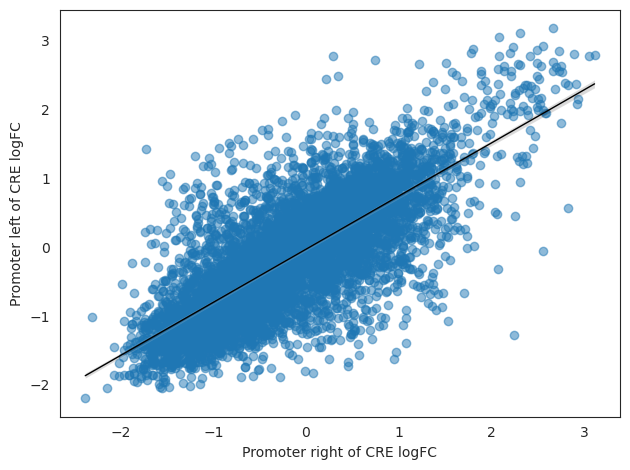

In [11]:
sns.regplot(data=binaware_pivot.to_pandas(), x="logFC_left", y="logFC_right", scatter_kws={'alpha':0.5}, line_kws=dict(color="black", lw=1))
plt.ylabel("Promoter left of CRE logFC")
plt.xlabel("Promoter right of CRE logFC")
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, "effect_of_bin_order_correlation.png")) #, format="pdf")

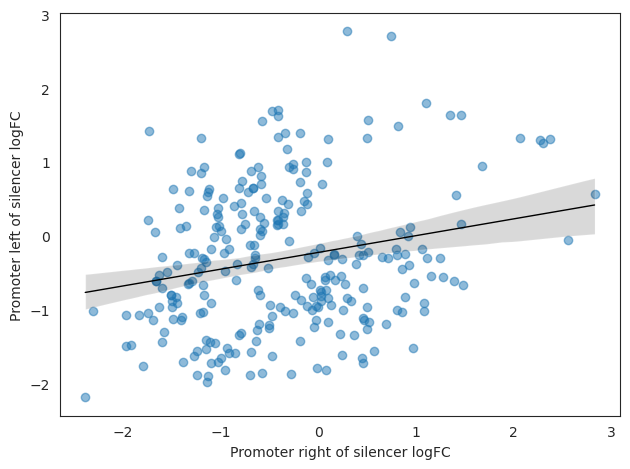

In [33]:
sns.regplot(data=binaware_pivot.filter(pl.any_horizontal(cs.matches("z_score") < -2)).to_pandas(), x="logFC_left", y="logFC_right", scatter_kws={'alpha':0.5}, line_kws=dict(color="black", lw=1))
plt.ylabel("Promoter left of silencer logFC")
plt.xlabel("Promoter right of silencer logFC")
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, "effect_of_bin_order_silencer_correlation.pdf"), format="pdf")

In [35]:
binaware_pivot.filter(pl.any_horizontal(cs.matches("z_score") < -2)).select(pl.corr("logFC_left", "logFC_right"), pl.corr("z_score_left", "z_score_right"))

logFC_left,z_score_left
f64,f64
0.223113,-0.654247


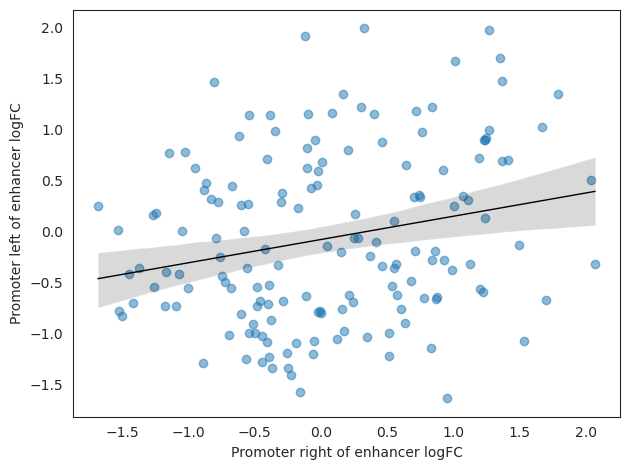

In [34]:
sns.regplot(data=binaware_pivot.filter(pl.any_horizontal(cs.matches("z_score") > 2)).to_pandas(), x="logFC_left", y="logFC_right", scatter_kws={'alpha':0.5}, line_kws=dict(color="black", lw=1))
plt.ylabel("Promoter left of enhancer logFC")
plt.xlabel("Promoter right of enhancer logFC")
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, "effect_of_bin_order_enhancer_correlation.pdf"), format="pdf")

In [36]:
binaware_pivot.filter(pl.any_horizontal(cs.matches("z_score") > 2)).select(pl.corr("logFC_left", "logFC_right"), pl.corr("z_score_left", "z_score_right"))

logFC_left,z_score_left
f64,f64
0.230246,-0.592027


## Orientation aware analysis

In [15]:
data_OA = data_OA.with_columns(
	pl.col("promoter").str.strip_chars_end("-+"),
	pl.col("OE").str.strip_chars_end("-+"),
	pl.col("promoter").str.tail(1).alias("prom_strand"),
	pl.col("OE").str.tail(1).alias("OE_strand"),
	).filter(pl.col("label") != "other - other")

In [16]:
both = data.join(
	data_OA.select("logFC", "nr_reads", "z_score", "effect", "promoter_only", "promoter", "OE", cs.matches("strand"), cs.matches("bin")), 
	on=["promoter", "OE"], suffix="_OA")

In [17]:
both.select(pl.corr("logFC", "logFC_OA"), pl.corr("z_score", "z_score_OA"))

logFC,z_score
f64,f64
0.927508,0.72631


In [18]:
data_OA.filter(pl.col("label") != "other - other").height

126228

In [19]:
data_OA.filter(pl.col("left_bin").len().over(["promoter", "OE"]) > 1).height

73486

In [20]:
multiple_orientations = data_OA.filter(pl.col("left_bin").len().over(["promoter", "OE"]) > 1).filter(pl.col("promoter").is_null().not_())
#multiple_orientations = multiple_orientations.filter(pl.col("z_score") <= -2)
# Now I should make a column with logFC of fwd and logFC of rev enhancer for same promoter
orientations_OE_pivot = multiple_orientations.filter(pl.col("promoter").is_null().not_()).select(
	"promoter", "OE", "prom_strand", "logFC", "z_score", "OE_strand"
	).pivot(on="OE_strand", index=["promoter", "OE", "prom_strand"], values=["logFC", "z_score"])


In [21]:

orientations_promoter_pivot = multiple_orientations.filter(pl.col("promoter").is_null().not_()).select(
	"promoter", "OE", "prom_strand", "logFC", "z_score", "OE_strand"
	).pivot(on="prom_strand", index=["promoter", "OE", "OE_strand"], values=["logFC", "z_score"])


In [22]:
orientations_both_pivot = multiple_orientations.filter(pl.col("promoter").is_null().not_()).select(
	"promoter", "OE", "prom_strand", "logFC", "z_score", "OE_strand"
	).filter(pl.col("OE_strand") == pl.col("prom_strand")) \
		.pivot(on=["prom_strand", "OE_strand"], index=["promoter", "OE"], values=["logFC", "z_score"]).drop_nulls()

orientations_both_pivot = orientations_both_pivot.rename(
	{
		"logFC_{\"+\",\"+\"}": "logFC_++",
		"logFC_{\"-\",\"-\"}": "logFC_--", 
		"z_score_{\"+\",\"+\"}": "z_score_++",
		"z_score_{\"-\",\"-\"}": "z_score_--"
	}
)

In [23]:
orientations_OE_pivot.select(pl.corr("logFC_-", "logFC_+"), pl.corr("z_score_-", "z_score_+"))

logFC_-,z_score_-
f64,f64
0.77673,0.336232


In [24]:
orientations_promoter_pivot.select(pl.corr("logFC_-", "logFC_+"), pl.corr("z_score_-", "z_score_+"))

logFC_-,z_score_-
f64,f64
0.628864,0.200582


In [25]:
orientations_both_pivot.select(pl.corr("logFC_--", "logFC_++"), pl.corr("z_score_--", "z_score_++"))

logFC_--,z_score_--
f64,f64
0.618329,0.204369


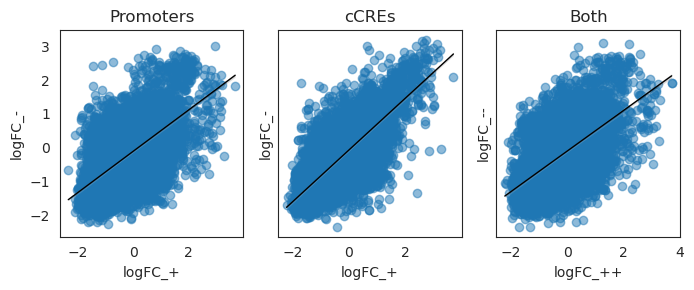

In [26]:
fig, axes = plt.subplots(ncols=3, sharey=True, figsize=(7, 3))

# for ax in axes:
#     ax.set(aspect='equal')

sns.regplot(data=orientations_promoter_pivot.to_pandas(), x="logFC_+", y="logFC_-", ax = axes[0], scatter_kws={'alpha':0.5}, line_kws=dict(color="black", lw=1))
sns.regplot(data=orientations_OE_pivot.to_pandas(), x="logFC_+", y="logFC_-", ax = axes[1], scatter_kws={'alpha':0.5}, line_kws=dict(color="black", lw=1))
sns.regplot(data=orientations_both_pivot.to_pandas(), x="logFC_++", y="logFC_--", ax = axes[2], scatter_kws={'alpha':0.5}, line_kws=dict(color="black", lw=1))
axes[0].set_title("Promoters")
axes[1].set_title("cCREs")
axes[2].set_title("Both")

plt.tight_layout()
plt.savefig(os.path.join(fig_dir, "orientation_correlation.png")) #, format="pdf")

## Effect of distance

In [5]:
plotting_data = promoa.filter(pl.col("right_bin").str.contains("null").not_())
plotting_data = plotting_data.filter((pl.col("label") != "other - other") 
									 & (pl.col("label") != "positive - positive")
									 & (pl.col("label") != "negative - negative")
									 & (pl.col("label") != "positive - target")
									 & (pl.col("label") != "target - target")
									 & (pl.col("label") != "negative - target")
)

#px.scatter(plotting_data.to_pandas(), x="dist", y="logFC", width=800, height=500)#, hue="adj.P.Val")

#sns.jointplot(data=plotting_data.to_pandas(), x="dist", y="z_score", hue="label", kind = "kde")

#plt.savefig(os.path.join(fig_dir, "distance_vs_z-score_per_type.pdf"), format="pdf")

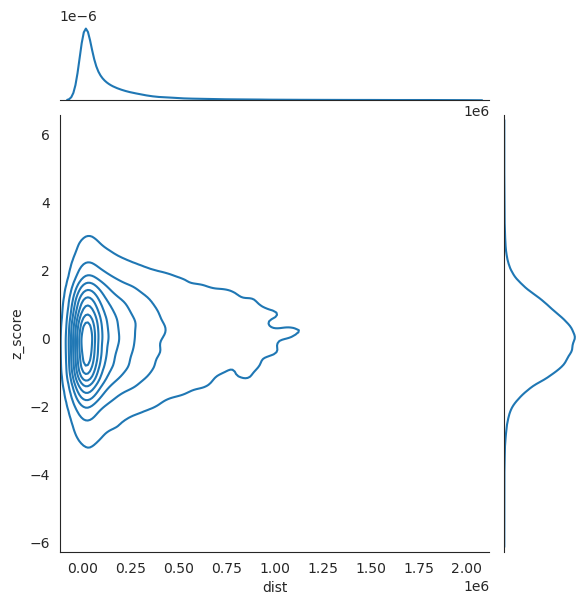

In [ ]:
# sns.jointplot(data=plotting_data.to_pandas(), x="dist", y="z_score", kind = "kde")
# plt.savefig(os.path.join(fig_dir, "distance_vs_z-score_kde.pdf"), format="pdf")

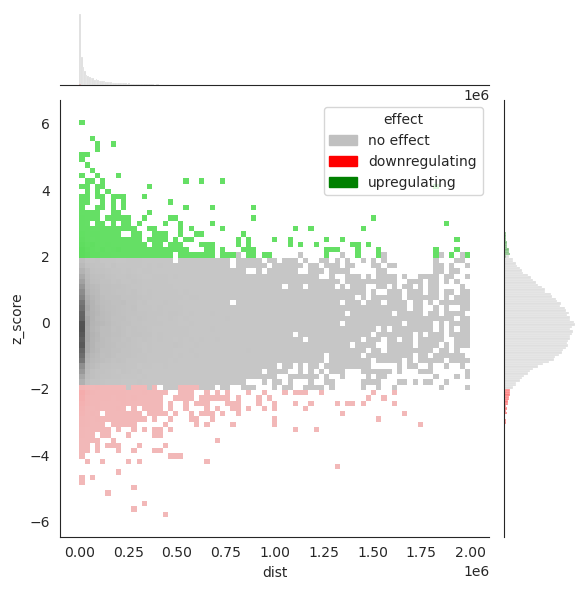

In [13]:
sns.jointplot(data=plotting_data.to_pandas(), x="dist", y="z_score", hue="effect", kind = "hist", 
			  palette={"downregulating": "red", "upregulating": "green", "no effect": "silver"}, bins=75, marginal_kws={'palette': {"downregulating": "red", "upregulating": "green", "no effect": "silver"}})
plt.savefig(os.path.join(fig_dir, "dist_vs_z-score_effect_hist.png")) #, format="pdf")

In [19]:
print("enhancer vs no effect",stats.ttest_ind(
	plotting_data.filter(pl.col("effect") == "upregulating").select("dist").to_numpy().flatten(), 
	plotting_data.filter(pl.col("effect") == "no effect").select("dist").to_numpy().flatten()))

print("enhancer vs silencer",stats.ttest_ind(
	plotting_data.filter(pl.col("effect") == "upregulating").select("dist").to_numpy().flatten(), 
	plotting_data.filter(pl.col("effect") == "downregulating").select("dist").to_numpy().flatten()))

print("silencer vs no effect",stats.ttest_ind(
	plotting_data.filter(pl.col("effect") == "downregulating").select("dist").to_numpy().flatten(), 
	plotting_data.filter(pl.col("effect") == "no effect").select("dist").to_numpy().flatten()))


enhancer vs no effect TtestResult(statistic=np.float64(6.112396905190889), pvalue=np.float64(9.879625654512896e-10), df=np.float64(55594.0))
enhancer vs silencer TtestResult(statistic=np.float64(4.202205131759835), pvalue=np.float64(2.752116602000926e-05), df=np.float64(2135.0))
silencer vs no effect TtestResult(statistic=np.float64(0.7016065311716867), pvalue=np.float64(0.48292749523248557), df=np.float64(55959.0))


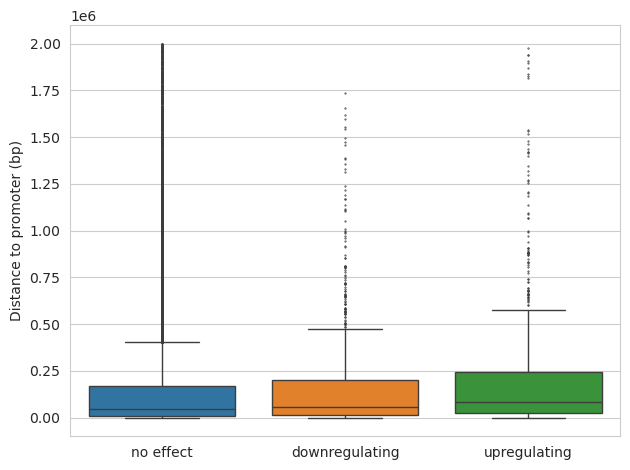

In [7]:
sns.set_style(style='whitegrid')
sns.boxplot(data=plotting_data.to_pandas(), x="effect", y="dist", hue="effect", fliersize=0.5, legend=False)
plt.xlabel("")
plt.ylabel("Distance to promoter (bp)")
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, "distance_to_promoter_boxplot.pdf"), format="pdf")

In [9]:
screen_OE = plotting_data.with_columns(pl.when(pl.col("targeted_left") == "unlabeled").then(pl.col("screen_left")).otherwise(pl.col("screen_right")).alias("SCREEN label"))
# Simplify the labels (when it contains "PLS", it is a promoter, when it contains "ELS", it is an enhancer)
screen_OE = screen_OE.with_columns(pl.when(pl.col("SCREEN label").str.contains("PLS")).then(pl.lit("known"))
									.when(pl.col("SCREEN label").str.contains("ELS")).then(pl.lit("known")).otherwise(pl.lit("unknown")).alias("SCREEN label")) \
									.filter(pl.col("effect") != "no effect")


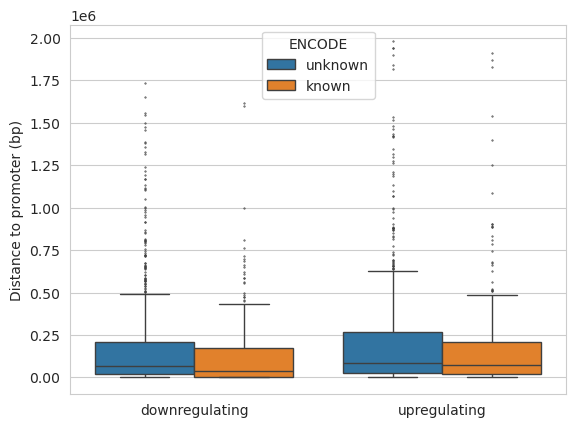

In [16]:
sns.set_style(style='whitegrid')
sns.boxplot(data=screen_OE.to_pandas(), x="effect", y="dist", hue="SCREEN label", fliersize=0.5)
plt.xlabel("")
plt.ylabel("Distance to promoter (bp)")
plt.legend(title="ENCODE")
plt.savefig(os.path.join(fig_dir, "SCREEN_distance_to_promoter_boxplot.png"))

In [15]:
print("known vs unknown silencers",stats.ttest_ind(
	screen_OE.filter(pl.col("effect") == "downregulating").filter(pl.col("SCREEN label") == "unknown").select("dist").to_numpy().flatten(), 
	screen_OE.filter(pl.col("effect") == "downregulating").filter(pl.col("SCREEN label") == "known").select("dist").to_numpy().flatten()))

print("known vs unknown enhancers",stats.ttest_ind(
	screen_OE.filter(pl.col("effect") == "upregulating").filter(pl.col("SCREEN label") == "unknown").select("dist").to_numpy().flatten(), 
	screen_OE.filter(pl.col("effect") == "upregulating").filter(pl.col("SCREEN label") == "known").select("dist").to_numpy().flatten()))

known vs unknown silencers TtestResult(statistic=np.float64(2.3927755580041494), pvalue=np.float64(0.016868472578719075), df=np.float64(1249.0))
known vs unknown enhancers TtestResult(statistic=np.float64(1.7195187056185062), pvalue=np.float64(0.08587000327965953), df=np.float64(884.0))


In [6]:
print(plotting_data.filter(pl.col("effect") == "upregulating").select(pl.corr("z_score", "dist"), pl.corr("logFC", "dist")))
print(plotting_data.filter(pl.col("effect") == "downregulating").select(pl.corr("z_score", "dist"), pl.corr("logFC", "dist")))
print(plotting_data.select(pl.corr("z_score", "dist"), pl.corr("logFC", "dist")))

shape: (1, 2)
┌───────────┬───────────┐
│ z_score   ┆ logFC     │
│ ---       ┆ ---       │
│ f64       ┆ f64       │
╞═══════════╪═══════════╡
│ -0.039623 ┆ -0.007949 │
└───────────┴───────────┘
shape: (1, 2)
┌───────────┬───────────┐
│ z_score   ┆ logFC     │
│ ---       ┆ ---       │
│ f64       ┆ f64       │
╞═══════════╪═══════════╡
│ -0.065372 ┆ -0.099053 │
└───────────┴───────────┘
shape: (1, 2)
┌──────────┬──────────┐
│ z_score  ┆ logFC    │
│ ---      ┆ ---      │
│ f64      ┆ f64      │
╞══════════╪══════════╡
│ 0.053823 ┆ 0.024245 │
└──────────┴──────────┘


## Effect of size

In [27]:
plotting_data = plotting_data.with_columns(
	size_left = pl.col("left_bin").str.split("-").list.get(2).cast(pl.Int32) - pl.col("left_bin").str.split("-").list.get(1).cast(pl.Int32),
	size_right = pl.col("right_bin").str.split("-").list.get(2).cast(pl.Int32) - pl.col("right_bin").str.split("-").list.get(1).cast(pl.Int32),
).with_columns(
	size = pl.col("size_left") + pl.col("size_right"),
	prom_size = pl.when(pl.col("targeted_left") != "unlabeled").then(pl.col("size_left")).otherwise(pl.col("size_right")),
	OE_size = pl.when(pl.col("targeted_left") == "unlabeled").then(pl.col("size_left")).otherwise(pl.col("size_right")),
)
sizes_separated = pl.concat([
	plotting_data.select("logFC", "z_score", size = "prom_size").with_columns(type= pl.lit("promoter size")),
	plotting_data.select("logFC", "z_score", size = "OE_size").with_columns(type= pl.lit("enhancer size"))])

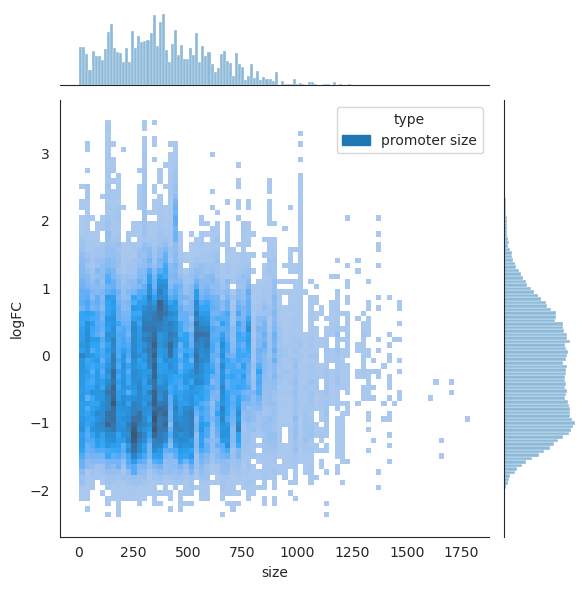

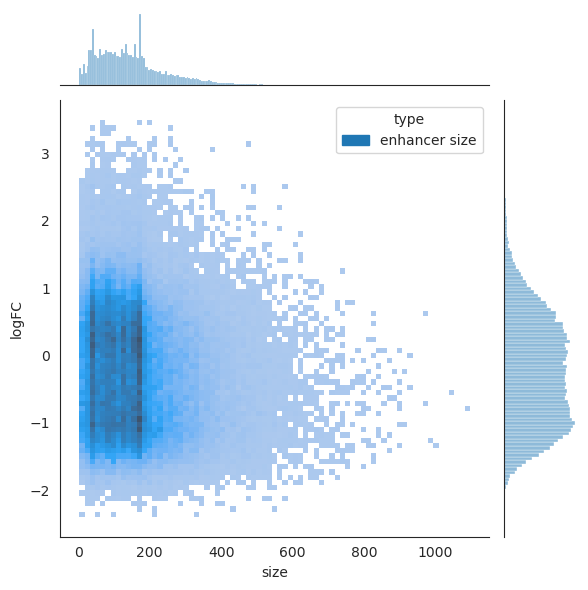

In [77]:
sns.jointplot(data=sizes_separated.filter(pl.col("type") == "promoter size").to_pandas(), x="size", y="logFC", hue="type", kind = "hist", bins=75)
plt.savefig(os.path.join(fig_dir, "size_vs_logFC_promoter.pdf"), format="pdf")
sns.jointplot(data=sizes_separated.filter(pl.col("type") == "enhancer size").to_pandas(), x="size", y="logFC", hue="type", kind = "hist", bins=75)
plt.savefig(os.path.join(fig_dir, "size_vs_logFC_enhancer.pdf"), format="pdf")

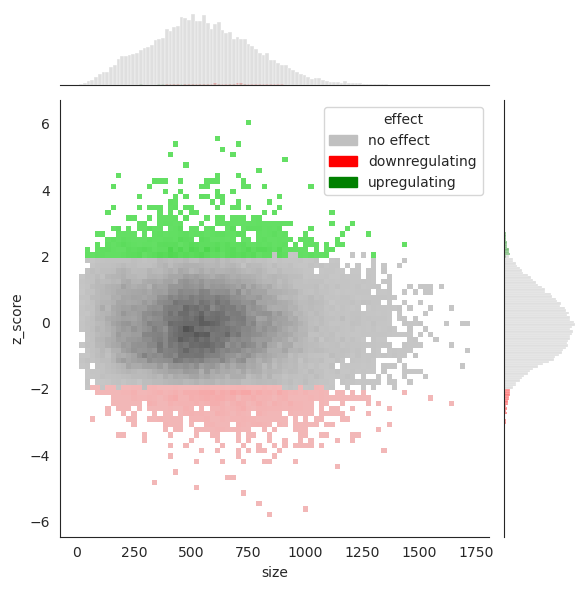

In [28]:
sns.jointplot(data=plotting_data.to_pandas(), x="size", y="z_score", hue="effect", kind = "hist", 
			  palette={"downregulating": "red", "upregulating": "green", "no effect": "silver"}, bins=75, marginal_kws={'palette': {"downregulating": "red", "upregulating": "green", "no effect": "silver"}})
plt.savefig(os.path.join(fig_dir, "size_vs_z-score_effect_hist.png")) #, format="pdf")

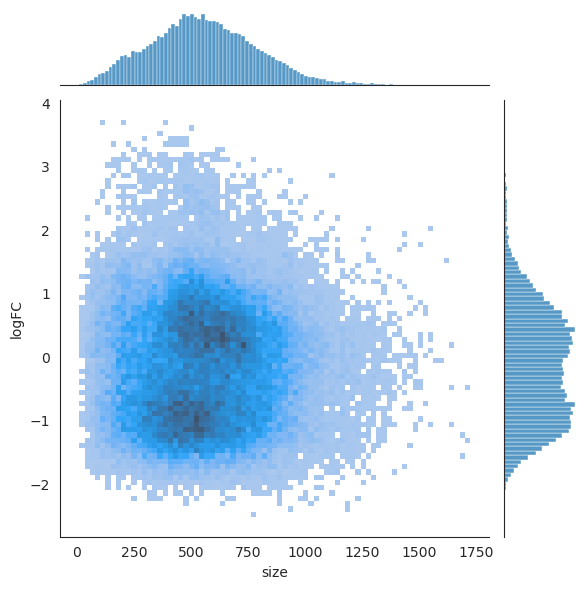

In [55]:
sns.jointplot(data=plotting_data.to_pandas(), x="size", y="logFC", kind = "hist", bins=75)
plt.savefig(os.path.join(fig_dir, "size_vs_logFC_hist.pdf"), format="pdf")

In [9]:
print(plotting_data.filter(pl.col("effect") == "upregulating").select(pl.corr("z_score", "size"), pl.corr("logFC", "size")))
print(plotting_data.filter(pl.col("effect") == "downregulating").select(pl.corr("z_score", "size"), pl.corr("logFC", "size")))
print(plotting_data.select(pl.corr("z_score", "size"), pl.corr("logFC", "size")))

shape: (1, 2)
┌─────────┬───────────┐
│ z_score ┆ logFC     │
│ ---     ┆ ---       │
│ f64     ┆ f64       │
╞═════════╪═══════════╡
│ 0.04029 ┆ -0.133857 │
└─────────┴───────────┘
shape: (1, 2)
┌───────────┬──────────┐
│ z_score   ┆ logFC    │
│ ---       ┆ ---      │
│ f64       ┆ f64      │
╞═══════════╪══════════╡
│ -0.132072 ┆ 0.032053 │
└───────────┴──────────┘
shape: (1, 2)
┌───────────┬───────────┐
│ z_score   ┆ logFC     │
│ ---       ┆ ---       │
│ f64       ┆ f64       │
╞═══════════╪═══════════╡
│ -0.041214 ┆ -0.004033 │
└───────────┴───────────┘


## known vs unknown enhancers

In [10]:
plotting_data = plotting_data.with_columns(
	pl.when(pl.col("left_bin") == pl.col("promoter")).then(pl.col("screen_right")).otherwise(pl.col("screen_left")).alias("SCREEN label OE"),
).with_columns(
	pl.when(pl.col("SCREEN label OE").str.contains("PLS")).then(pl.lit("known promoter"))
		 .when(pl.col("SCREEN label OE").str.contains("ELS")).then(pl.lit("known enhancer"))
		 .otherwise(pl.lit("unknown")).alias("SCREEN label OE")
)

In [11]:
plotting_data.select(pl.col("SCREEN label OE").value_counts())

SCREEN label OE
struct[2]
"{""known promoter"",1440}"
"{""unknown"",43594}"
"{""known enhancer"",14149}"


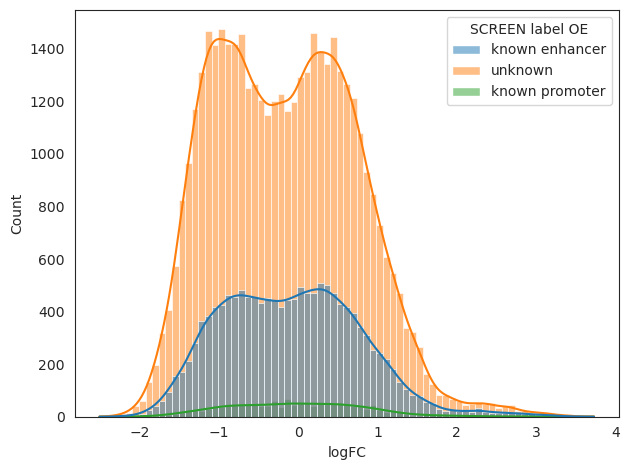

In [12]:
sns.histplot(plotting_data.to_pandas(), x="logFC", hue="SCREEN label OE", bins=75, kde=True)
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, "logFC_per_screen_label.pdf"), format="pdf")

## per bait type in known enhancers 

In [ ]:
def ridge_plot(data, x, y, order=None, title=None):
	pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
	g = sns.FacetGrid(data.to_pandas(), row=y, hue=y, aspect=13, height=.5, palette=pal, row_order=order, xlim=(-2.2, 2.5))

	# Draw the densities in a few steps
	g.map(sns.kdeplot, x, 
		bw_adjust=.5, clip_on=True,
		fill=True, alpha=1, linewidth=1.5)
	g.map(sns.kdeplot, x, clip_on=False, color="w", lw=2, bw_adjust=.5)

	# passing color=None to refline() uses the hue mapping
	g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

	def label(x, color, label):
		ax = plt.gca()
		ax.text(-0.5, .2, label, fontweight="bold", color=color,fontsize=13,
				ha="left", va="center", transform=ax.transAxes)


	g.figure.subplots_adjust(hspace=-.3)
	g.figure.suptitle(title) #, fontsize=20)

	g.map(label, x)
	g.set_titles("")
	g.set(yticks=[], ylabel="")
	g.set(xlim=(-2.2, 2.5))
	g.despine(bottom=True, left=True)

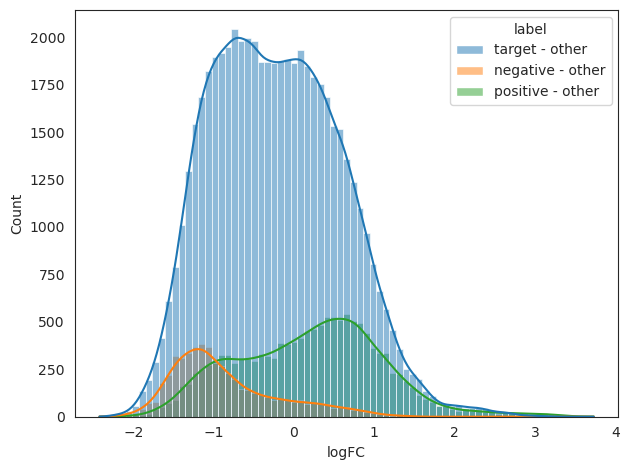

In [15]:
known = plotting_data.filter(pl.col("SCREEN label OE") != "unknown")
sns.histplot(known.to_pandas(), x="logFC", hue="label", bins=75, kde=True)
plt.tight_layout()
#plt.savefig(os.path.join(fig_dir, "known_interactors_hist_plot.pdf"), format="pdf")

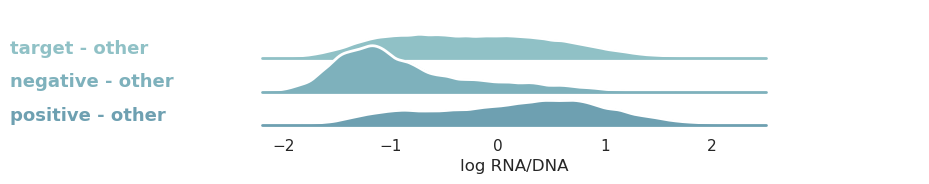

In [16]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
ridge_plot(known.rename({"logFC": "log RNA/DNA"}), "log RNA/DNA", "label")
#plt.savefig(os.path.join(fig_dir, "known_interactors_ridge_plot.pdf"), format="pdf", transparent=True, bbox_inches = "tight")

## Interaction frequency vs activity

In [46]:
contact_counts = pl.read_csv(os.path.join(fig_dir, "hic_counts.tsv.gz"), skip_lines=1, separator="\t")

In [49]:
data_with_contacts = promoa.with_columns(
	pl.col("promoter").str.strip_chars_end("-+"),
	pl.col("OE").str.strip_chars_end("-+"),
	).join(
		contact_counts, left_on=["promoter", "OE"], right_on=["baitID", "otherEndID"]
)

<Axes: xlabel='N', ylabel='z_score'>

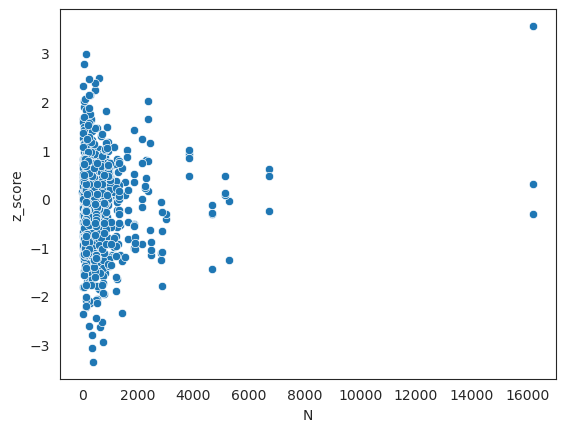

In [51]:
sns.scatterplot(data_with_contacts.to_pandas(), x="N", y="z_score")

In [53]:
data_with_contacts.select(pl.corr("z_score", "N"), pl.corr("logFC", "N"))

z_score,logFC
f64,f64
0.072101,0.119206


In [44]:
data.head()

logFC,adj.P.Val,P.Value,left_bin,right_bin,nr_reads,any_tss,screen_left,screen_right,targeted_left,targeted_right,target_gene_left,target_gene_right,label,interaction,dist,target_genes,promoter,OE,promoter_only,std,effect,z_score
f64,f64,f64,str,str,i64,str,str,str,str,str,str,str,str,str,f64,str,str,str,f64,f64,str,f64
-0.172829,0.208185,0.173521,"""chr12-49366545-49367145""","""chr12-49478723-49478769""",13,"""no""","""pELS,CTCF-bound,PLS,CTCF-bound""","""none""","""target""","""unlabeled""","""SPATS2""","""unlabeled""","""target - other""","""PLS - ELS""",111901.0,"""SPATS2""","""chr12-49366545-49367145""","""chr12-49478723-49478769""",-0.361189,0.401474,"""no effect""",0.469172
-0.736648,0.001198,0.000688,"""chr20-53550518-53550622""","""chr20-54207771-54208166""",6,"""yes""","""none""","""pELS,CTCF-bound,PLS,CTCF-bound""","""unlabeled""","""target""","""unlabeled""","""PFDN4""","""target - other""","""PLS - ELS""",657398.5,"""PFDN4""","""chr20-54207771-54208166""","""chr20-53550518-53550622""",-0.150104,0.557219,"""no effect""",-1.052629
0.307251,0.062243,0.047009,"""chr3-142604417-142604606""","""chr3-143001562-143001650""",9,"""yes""","""none""","""PLS,CTCF-bound""","""unlabeled""","""target""","""unlabeled""","""U2SURP""","""target - other""","""PLS - undefined""",397094.5,"""U2SURP""","""chr3-143001562-143001650""","""chr3-142604417-142604606""",0.776216,0.813927,"""no effect""",-0.576176
0.037516,0.840014,0.81542,"""chr20-45416356-45416455""","""chr20-45955943-45955971""",11,"""no""","""pELS,CTCF-bound""","""none""","""unlabeled""","""unlabeled""","""unlabeled""","""unlabeled""","""other - other""","""ELS - undefined""",539551.5,null,null,null,null,null,null,null
-1.313186,1.9127e-8,4.7874e-9,"""chr1-146092930-146093149""","""chr1-146146077-146146543""",7,"""no""","""none""","""none""","""unlabeled""","""unlabeled""","""unlabeled""","""unlabeled""","""other - other""","""undefined""",53270.5,null,null,null,null,null,null,null


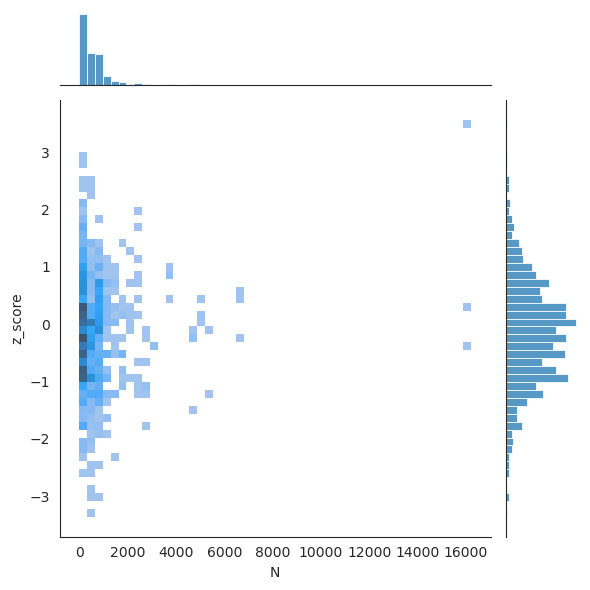

In [56]:
sns.jointplot(data=data_with_contacts.to_pandas(), x="N", y="z_score", kind = "hist", bins=50, marginal_kws=dict(bins=50))
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, "contacts_vs_z-score_hist.pdf"), format="pdf")

<Axes: xlabel='logFC', ylabel='Count'>

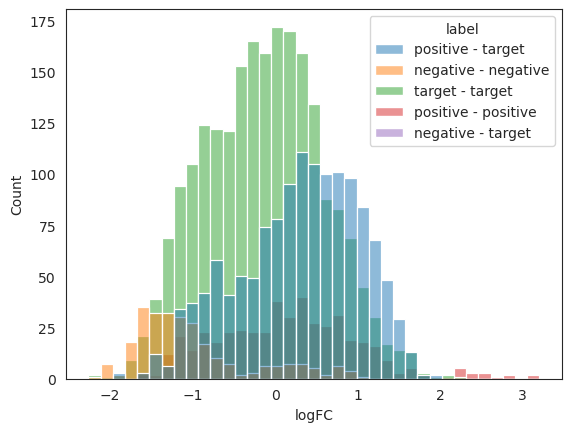

In [59]:
sns.histplot(data=promoa.filter(pl.col("label").str.contains("other").not_()), x="logFC", hue="label")

## Combinatorial effect of promoters

In [8]:
# To make it ENCODE only: promoa.filter(pl.col("interaction").is_not_null())

prom_only_logfcs = promoa.filter(
	pl.col("right_bin").str.contains("null")).select(promoter = "left_bin", promoter_only = "logFC")

In [9]:
two_proms = promoa.join(
	prom_only_logfcs, left_on="left_bin", right_on="promoter", suffix="_left").join(prom_only_logfcs, left_on="right_bin", right_on="promoter", suffix="_right")

## THIS IS TO TAKE MAX ACTIVITY
max_z = promoa.filter((pl.col("label").str.contains("other"))).group_by("promoter").agg(max_logfc = pl.col("logFC").max())
prom_enh = promoa.join(max_z, on="promoter").filter(pl.col("logFC") == pl.col("max_logfc"))#.select("promoter", "OE", "z_score")

## THIS IS TO TAKE MEDIAN ACTIVITY
max_z = promoa.filter((pl.col("label").str.contains("other"))).group_by("promoter").agg(logFC = pl.col("logFC").median())
prom_enh = max_z #promoa.join(max_z, on="promoter").filter(pl.col("logFC") == pl.col("max_logfc"))#.select("promoter", "OE", "z_score")

#prom_enh = promoa.filter((pl.col("label").str.contains("other"))).group_by("promoter").agg(pl.col("logFC").median())
two_proms = two_proms.join(prom_enh, left_on="left_bin", right_on="promoter", suffix="_leftenh")
two_proms = two_proms.join(prom_enh, left_on="right_bin", right_on="promoter", suffix="_rightenh")
two_proms = two_proms.with_columns(enh_avg = (pl.col("logFC_leftenh") + pl.col("logFC_rightenh"))/2)
two_proms = two_proms.with_columns(promoter_avg = (pl.col("promoter_only_left") + pl.col("promoter_only_right"))/2)
two_proms = two_proms.select("left_bin", "right_bin", "promoter_avg", "logFC", "enh_avg")
to_plot = two_proms.unpivot(index=["left_bin", "right_bin"]).with_columns( id = pl.col("left_bin")+ pl.col("right_bin"))
to_plot = to_plot.with_columns(pl.col("variable").str.replace("enh_avg", "Promoter - enhancer").str.replace("promoter_avg", "Single promoter")
							   .str.replace("logFC", "Combined promoters"))

In [10]:
print(pl.concat([to_plot.select(bin=pl.col("left_bin")), to_plot.select(bin=pl.col("right_bin"))]).n_unique())
print(pl.concat([to_plot.select(bin=pl.col("left_bin")), to_plot.select(bin=pl.col("right_bin"))]).select(pl.col("bin").str.strip_chars_end("-+")).n_unique())

843
820


In [18]:
pl.concat([to_plot.select(bin=pl.col("left_bin")), to_plot.select(bin=pl.col("right_bin"))]
		  ).join(promoa, left_on = "bin", right_on="promoter"
		   ).unique("bin").group_by("label").count()

label,count
str,u32
"""target - other""",594
"""positive - other""",141
"""negative - other""",108


In [10]:
pl.concat([to_plot.select(bin=pl.col("left_bin")), to_plot.select(bin=pl.col("right_bin"))]).select(pl.col("bin").str.strip_chars_end("-+")).head()

bin
str
"""chr8-17922525-17922619"""
"""chr14-23034803-23035146"""
"""chr1-153990304-153990546"""
"""chr11-115504278-115504365"""
"""chr20-45890782-45891172"""


In [9]:
to_plot.select(pl.col("variable").value_counts())

variable
struct[2]
"{""Promoter - enhancer"",2675}"
"{""Combined promoters"",2675}"
"{""Single promoter"",2675}"


In [20]:
# print(stats.ttest_rel(two_proms.select("promoter_only_left").to_numpy().flatten(), two_proms.select("logFC").to_numpy().flatten()))
# print(stats.ttest_rel(two_proms.select("promoter_only_left").to_numpy().flatten(), two_proms.select("promoter_only_right").to_numpy().flatten()))
# print(stats.ttest_rel(two_proms.select("promoter_only_right").to_numpy().flatten(), two_proms.select("logFC").to_numpy().flatten()))
print("single vs double:",stats.ttest_rel(two_proms.select("promoter_avg").to_numpy().flatten(), two_proms.select("logFC").to_numpy().flatten()))
print("max enhancer vs double:",stats.ttest_rel(two_proms.select("promoter_avg").to_numpy().flatten(), two_proms.select("enh_avg").to_numpy().flatten()))
print("single vs max enhancer:",stats.ttest_rel(two_proms.select("enh_avg").to_numpy().flatten(), two_proms.select("logFC").to_numpy().flatten()))

single vs double: TtestResult(statistic=np.float64(-5.2163400776829505), pvalue=np.float64(2.2418356786550394e-07), df=np.int64(947))
max enhancer vs double: TtestResult(statistic=np.float64(-60.95779750331738), pvalue=np.float64(0.0), df=np.int64(947))
single vs max enhancer: TtestResult(statistic=np.float64(46.70807193619836), pvalue=np.float64(5.524815856807391e-248), df=np.int64(947))


In [12]:
two_proms.mean()

left_bin,right_bin,promoter_avg,logFC,enh_avg
str,str,f64,f64,f64
null,null,-0.167795,-0.08019,0.808446


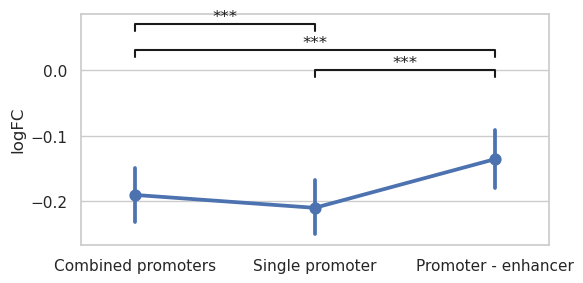

In [32]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(6, 3))
sns.pointplot(data=to_plot.with_columns(pl.col("variable").sort_by("value")).to_pandas(), x="variable", y="value")
plt.ylabel("logFC")
plt.xlabel("")
#ax.set_xticklabels(["Combined promoters", "Single promoter"]) #, rotation=10)

# statistical annotation
x1, x2 = 0, 1   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = 0.06, 0.01, 'k'

plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)

x1, x2 = 1, 2   
y, h, col = -0.01, 0.01, 'k'

plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)

x1, x2 = 0, 2   
y, h, col = 0.02, 0.01, 'k'

plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)

plt.xlim(-0.3, 2.3)
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, "promoter_combinatorial_effect.pdf"), format="pdf")

In [27]:
to_plot_two = promoa.filter(pl.col("label") != "other - other").with_columns(
	pl.when(pl.col("right_bin").str.contains("null")).then(pl.lit("single promoter"))
	.when(pl.col("label").str.contains("other")).then(pl.lit("promoter - enhancer"))
	.when(pl.col("label").str.contains("other").not_()).then(pl.lit("combined promoters")).alias("type") 
)



In [34]:
print(stats.ttest_ind(to_plot_two.filter(pl.col("type") == "single promoter").select("logFC").to_numpy().flatten(), 
					  to_plot_two.filter(pl.col("type") == "promoter - enhancer").select("logFC").to_numpy().flatten()))
print(stats.ttest_ind(to_plot_two.filter(pl.col("type") == "single promoter").select("logFC").to_numpy().flatten(), 
					  to_plot_two.filter(pl.col("type") == "combined promoters").select("logFC").to_numpy().flatten()))
print(stats.ttest_ind(to_plot_two.filter(pl.col("type") == "combined promoters").select("logFC").to_numpy().flatten(), 
					  to_plot_two.filter(pl.col("type") == "promoter - enhancer").select("logFC").to_numpy().flatten()))

TtestResult(statistic=-7.793472621796056, pvalue=6.5720581177524754e-15, df=117950.0)
TtestResult(statistic=-16.91955966255471, pvalue=6.304858388148423e-63, df=6752.0)
TtestResult(statistic=15.18667065286176, pvalue=4.846990569525697e-52, df=119698.0)


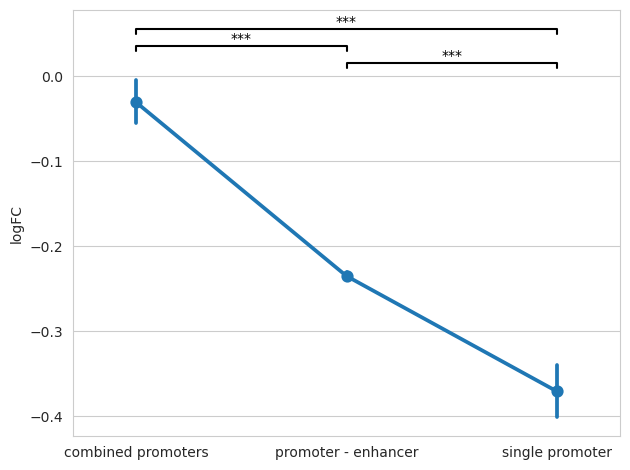

In [44]:
sns.set_style("whitegrid")
sns.pointplot(data=to_plot_two.sort("type").to_pandas(), x="type", y="logFC")

x1, x2 = 0, 1  
y, h, col = 0.03, 0.005, 'k'

plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)

x1, x2 = 1, 2  
y, h, col = 0.01, 0.005, 'k'

plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)

x1, x2 = 0, 2  
y, h, col = 0.05, 0.005, 'k'

plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)

plt.xlim(-0.3, 2.3)
plt.ylabel("logFC")
plt.xlabel("")
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, "promoter_combinatorial_effect_independent.pdf"), format="pdf")

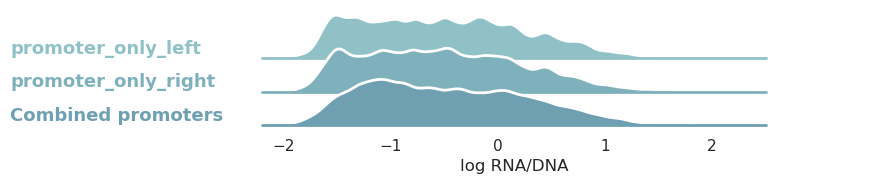

In [25]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
ridge_plot(to_plot.rename({"value": "log RNA/DNA"}), "log RNA/DNA", "variable")

## Distance vs H3k4me3 overlaps

In [17]:
enh_h3k4me3_ids = pl.read_csv("/data/cephfs-2/unmirrored/groups/kircher/MPRA/CaptureCMPRA/results/manuscript_figures/CRE_enrichment_plot/upregulating_OEs_nonprom_H3K4me3_overlap.bed", separator="\t", has_header=False, new_columns=["OE"])
sil_h3k4me3_ids = pl.read_csv("/data/cephfs-2/unmirrored/groups/kircher/MPRA/CaptureCMPRA/results/manuscript_figures/CRE_enrichment_plot/downregulating_OEs_nonprom_H3K4me3_overlap.bed", separator="\t", has_header=False, new_columns=["OE"])
enh_h3k4me3 = enh_h3k4me3_ids.join(plotting_data.filter(pl.col("effect") == "upregulating" ), on="OE")
sil_h3k4me3 = sil_h3k4me3_ids.join(plotting_data.filter(pl.col("effect") == "downregulating"), on="OE")
enh_non_h3k4me3 = plotting_data.filter(pl.col("effect") == "upregulating" ).join(enh_h3k4me3, on="OE", how="anti")
sil_non_h3k4me3 = plotting_data.filter(pl.col("effect") == "downregulating" ).join(sil_h3k4me3, on="OE", how="anti")
h3k4me3 = pl.concat([enh_h3k4me3, sil_h3k4me3])
non_h3k4me3 = pl.concat([enh_non_h3k4me3, sil_non_h3k4me3])

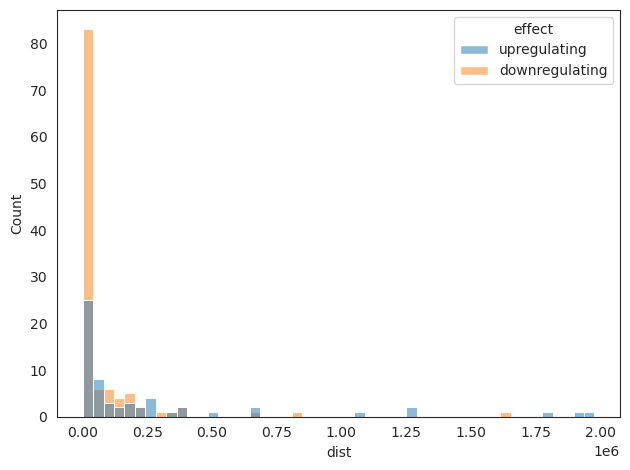

In [14]:
sns.histplot(h3k4me3.to_pandas(), x="dist", hue="effect")
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, "h3k4me3_distance_hist.pdf"), format="pdf")

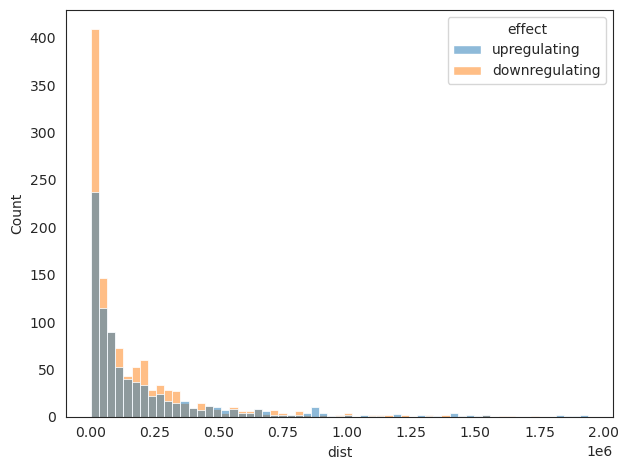

In [18]:
sns.histplot(non_h3k4me3.to_pandas(), x="dist", hue="effect")
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, "non_h3k4me3_distance_hist.pdf"), format="pdf")

In [21]:
h3k4me3.select(med = pl.col("dist").median(), mean = pl.col("dist").mean())

med,mean
f64,f64
5404.0,134987.52907


In [22]:
non_h3k4me3.select(med = pl.col("dist").median(), mean = pl.col("dist").mean())

med,mean
f64,f64
75716.5,184700.894201


In [28]:
non_h3k4me3.filter(pl.col("effect") == "upregulating").select(med = pl.col("dist").median(), mean = pl.col("dist").mean())

med,mean
f64,f64
84233.75,207450.883454
